In [1]:
# import libraries for dataframing and visualation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re

# !pip install textblob
from textblob import TextBlob, Word

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import ImageColorGenerator

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import linear_kernel # for cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data from csv file
allgame_data = pd.read_csv("all_games.csv")

In [3]:
# display the pandas dataframe
allgame_data

,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Grand Theft Auto IV,Xbox 360,"April 29, 2008",[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,7.9
...,...,...,...,...,...,...
18795,Fast & Furious: Showdown,Xbox 360,"May 21, 2013",Fast & Furious: Showdown takes some of the fra...,22,1.3
18796,Drake of the 99 Dragons,Xbox,"November 3, 2003",Drake is out for revenge in a supernatural Hon...,22,1.7
18797,Afro Samurai 2: Revenge of Kuma Volume One,PlayStation 4,"September 22, 2015","Head out on a journey of redemption, driven by...",21,2.9
18798,Infestation: Survivor Stories (The War Z),PC,"October 15, 2012","(Formerly known as ""The War Z"") It has been 5 ...",20,1.7


In [4]:
# show all unique names
# I'm doing this because after looking through the dataset in excel some games appear more than once
# This is certain games were released on multiple platforms so we could have Halo on PC, Xbox 360 and Playstation 3
# all of which are counted as different entries
allgame_data['name'].nunique()

12254

In [5]:
# So here we're just going to drop the duplicates

allgame_data.drop_duplicates('name',keep='first', inplace=True)

allgame_data.reset_index(drop=True, inplace=True)

allgame_data

,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Super Mario Galaxy,Wii,"November 12, 2007",[Metacritic's 2007 Wii Game of the Year] The u...,97,9.1
...,...,...,...,...,...,...
12249,Charlie's Angels,GameCube,"July 9, 2003","Join Natalie, Dylan, and Alex for an intense a...",23,4.3
12250,Fast & Furious: Showdown,Xbox 360,"May 21, 2013",Fast & Furious: Showdown takes some of the fra...,22,1.3
12251,Drake of the 99 Dragons,Xbox,"November 3, 2003",Drake is out for revenge in a supernatural Hon...,22,1.7
12252,Afro Samurai 2: Revenge of Kuma Volume One,PlayStation 4,"September 22, 2015","Head out on a journey of redemption, driven by...",21,2.9


In [6]:
# view descriptive statistics of the data
allgame_data.describe()

,meta_score
count,12254.000000
mean,70.743104
std,12.418369
min,20.000000
25%,64.000000
50%,73.000000
75%,80.000000
max,99.000000


In [7]:
# print a concise summary of the dataframe
allgame_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12254 entries, 0 to 12253
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          12254 non-null  object
 1   platform      12254 non-null  object
 2   release_date  12254 non-null  object
 3   summary       12153 non-null  object
 4   meta_score    12254 non-null  int64 
 5   user_review   12254 non-null  object
dtypes: int64(1), object(5)
memory usage: 574.5+ KB


In [8]:
# drop entries with missing values
null_rows = allgame_data[allgame_data['summary'].isnull()].index

allgame_data.drop(index=null_rows, inplace=True)

allgame_data

,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Super Mario Galaxy,Wii,"November 12, 2007",[Metacritic's 2007 Wii Game of the Year] The u...,97,9.1
...,...,...,...,...,...,...
12249,Charlie's Angels,GameCube,"July 9, 2003","Join Natalie, Dylan, and Alex for an intense a...",23,4.3
12250,Fast & Furious: Showdown,Xbox 360,"May 21, 2013",Fast & Furious: Showdown takes some of the fra...,22,1.3
12251,Drake of the 99 Dragons,Xbox,"November 3, 2003",Drake is out for revenge in a supernatural Hon...,22,1.7
12252,Afro Samurai 2: Revenge of Kuma Volume One,PlayStation 4,"September 22, 2015","Head out on a journey of redemption, driven by...",21,2.9


In [9]:
# viewing the summary again but without the null values and dropped rows
allgame_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12153 entries, 0 to 12253
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          12153 non-null  object
 1   platform      12153 non-null  object
 2   release_date  12153 non-null  object
 3   summary       12153 non-null  object
 4   meta_score    12153 non-null  int64 
 5   user_review   12153 non-null  object
dtypes: int64(1), object(5)
memory usage: 664.6+ KB


In [10]:
# define a class to remove punctuation
class PunctuationRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.remove_punctuations(text))
    
    def remove_punctuations(self, text):
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        return text

# Create a pipeline
pipeline = Pipeline([
    ('punctuation_remover', PunctuationRemover()),
])

# Apply the pipeline to our data
allgame_data['summarypunc'] = pipeline.transform(allgame_data['summary'])

print(allgame_data['summarypunc'].head())

0    As a young boy Link is tricked by Ganondorf th...
1    As most major publishers development efforts s...
2    Metacritics 2008 PS3 Game of the Year Also kno...
3    This is a tale of souls and swords transcendin...
4    Metacritics 2007 Wii Game of the Year The ulti...
Name: summarypunc, dtype: object


In [11]:
# define a class to make the data into lower case
class LowerCaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: " ".join(x.lower() for x in x.split()))

# Create a pipeline
pipeline = Pipeline([
    ('lowercase', LowerCaseTransformer()),
])

# Apply the pipeline to your data
allgame_data['summarypunc'] = pipeline.transform(allgame_data['summarypunc'])

print(allgame_data['summarypunc'].head())

0    as a young boy link is tricked by ganondorf th...
1    as most major publishers development efforts s...
2    metacritics 2008 ps3 game of the year also kno...
3    this is a tale of souls and swords transcendin...
4    metacritics 2007 wii game of the year the ulti...
Name: summarypunc, dtype: object


In [12]:
# define a class to remove stop words
class StopWordsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.remove_stop_words(text))
    
    def remove_stop_words(self, text):
        return " ".join(x for x in text.split() if x not in self.stop_words)

# Define or import the list of stop words
stop = stopwords.words('english')

# Create a pipeline
pipeline = Pipeline([
    ('stopwords_remover', StopWordsRemover(stop_words=stop)),
])

# Apply the pipeline to your data
allgame_data['summarypunc'] = pipeline.transform(allgame_data['summarypunc'])

print(allgame_data['summarypunc'].head())

0    young boy link tricked ganondorf king gerudo t...
1    major publishers development efforts shift num...
2    metacritics 2008 ps3 game year also known gta ...
3    tale souls swords transcending world history t...
4    metacritics 2007 wii game year ultimate ninten...
Name: summarypunc, dtype: object


In [13]:
# define a class to remove rare words
class RareWordsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, rare_words):
        self.rare_words = rare_words
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.remove_rare_words(text))
    
    def remove_rare_words(self, text):
        return " ".join(x for x in text.split() if x not in self.rare_words)

# Calculate the frequency of words
freq = pd.Series(' '.join(allgame_data['summarypunc']).split()).value_counts()[-10:]
freq = list(freq.index)

# Create a pipeline
pipeline = Pipeline([
    ('rare_words_remover', RareWordsRemover(rare_words=freq)),
])

# Apply the pipeline to your data
allgame_data['summarypunc'] = pipeline.transform(allgame_data['summarypunc'])

print(allgame_data['summarypunc'].head())

0    young boy link tricked ganondorf king gerudo t...
1    major publishers development efforts shift num...
2    metacritics 2008 ps3 game year also known gta ...
3    tale souls swords transcending world history t...
4    metacritics 2007 wii game year ultimate ninten...
Name: summarypunc, dtype: object


In [14]:
# define a class to add tokens to words
class TokenizerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.tokenize(text))
    
    def tokenize(self, text):
        return TextBlob(text).words

# Create a pipeline
pipeline = Pipeline([
    ('tokenizer', TokenizerTransformer()),
])

# Apply the pipeline to your data
tokens_data = pipeline.transform(allgame_data['summarypunc'])

print(tokens_data)

0        [young, boy, link, tricked, ganondorf, king, g...
1        [major, publishers, development, efforts, shif...
2        [metacritics, 2008, ps3, game, year, also, kno...
3        [tale, souls, swords, transcending, world, his...
4        [metacritics, 2007, wii, game, year, ultimate,...
                               ...                        
12249    [join, natalie, dylan, alex, intense, adventur...
12250    [fast, furious, showdown, takes, franchise, ’,...
12251    [drake, revenge, supernatural, hong, kong, wor...
12252    [head, journey, redemption, driven, bitterswee...
12253    [formerly, known, war, z, 5, years, since, out...
Name: summarypunc, Length: 12153, dtype: object


In [15]:
# define a class to apply stemming
class StemmerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.stem(text))
    
    def stem(self, text):
        return " ".join([self.stemmer.stem(word) for word in text.split()])

# Create a pipeline
pipeline = Pipeline([
    ('stemmer', StemmerTransformer(stemmer=PorterStemmer())),
])

# Apply the pipeline to your data
stemmed_data = pipeline.transform(allgame_data['summarypunc'][:5])

print(stemmed_data)

0    young boy link trick ganondorf king gerudo thi...
1    major publish develop effort shift number next...
2    metacrit 2008 ps3 game year also known gta iv ...
3    tale soul sword transcend world histori told e...
4    metacrit 2007 wii game year ultim nintendo her...
Name: summarypunc, dtype: object


In [16]:
# define a class to add lemmatization
class LemmatizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatizer):
        self.lemmatizer = lemmatizer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.lemmatize(text))
    
    def lemmatize(self, text):
        return " ".join([self.lemmatizer.lemmatize(word) for word in text.split()])

# Create a pipeline
pipeline = Pipeline([
    ('lemmatizer', LemmatizerTransformer(lemmatizer=WordNetLemmatizer())),
])

# Apply the pipeline to your data
allgame_data['summarypunc'] = pipeline.transform(allgame_data['summarypunc'])

print(allgame_data['summarypunc'].head())

0    young boy link tricked ganondorf king gerudo t...
1    major publisher development effort shift numbe...
2    metacritics 2008 ps3 game year also known gta ...
3    tale soul sword transcending world history tol...
4    metacritics 2007 wii game year ultimate ninten...
Name: summarypunc, dtype: object


In [17]:
# create a copy of the data for word clouds *not necessary
wordf = allgame_data.copy()

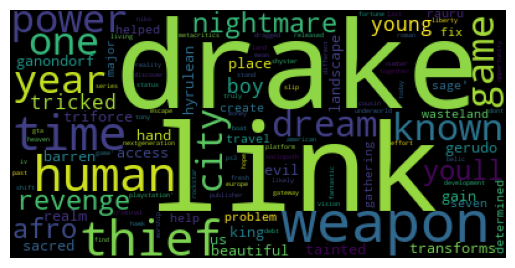

In [18]:
# instaniate values to dict
game_corpus = wordf['summarypunc'].values 

# generate word cloud from values from summary column
wordcloud = WordCloud().generate(str(game_corpus))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

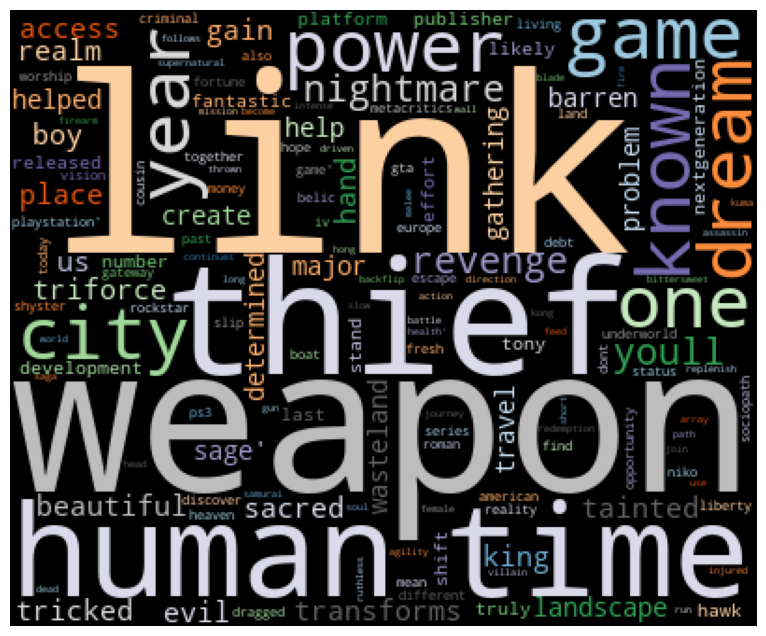

In [19]:
#Define a list of stop words
stopwords = ['ganondorf', 'gerudo', 'rauru', 'seven', 'hyrulean', 'fix',
             'afro', 'young', 'drake']

game_corpus = wordf['summarypunc'].values 

#A function to generate the word cloud from text
cloud = WordCloud(width=400, height=330, max_words=150, colormap='tab20c', stopwords=stopwords,collocations=True).generate(str(game_corpus))
    
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [20]:
# define a class to create ngrams
class NgramTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.generate_ngrams(text))
    
    def generate_ngrams(self, text):
        return TextBlob(text).ngrams(self.n)

# Create a pipeline
pipeline = Pipeline([
    ('ngram_generator', NgramTransformer(n=2)),
])

# Apply the pipeline to your data
ngrams_data = pipeline.transform(allgame_data['summarypunc'])

print(ngrams_data)

0        [[young, boy], [boy, link], [link, tricked], [...
1        [[major, publisher], [publisher, development],...
2        [[metacritics, 2008], [2008, ps3], [ps3, game]...
3        [[tale, soul], [soul, sword], [sword, transcen...
4        [[metacritics, 2007], [2007, wii], [wii, game]...
                               ...                        
12249    [[join, natalie], [natalie, dylan], [dylan, al...
12250    [[fast, furious], [furious, showdown], [showdo...
12251    [[drake, revenge], [revenge, supernatural], [s...
12252    [[head, journey], [journey, redemption], [rede...
12253    [[formerly, known], [known, war], [war, z], [z...
Name: summarypunc, Length: 12153, dtype: object


In [21]:
# instaniate values to dict
documents_list= allgame_data['summarypunc'].tolist()

In [22]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(documents_list)   

In [23]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(documents_list)  

In [24]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [25]:
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['batman', 'arkham', 'umbrella', 'redfield', 'raccoon', 'claire', 'revelation']
Topic 1:  ['game', 'new', 'player', 'world', 'battle', 'adventure', 'character']
Topic 2:  ['mode', 'game', 'player', 'new', 'racing', 'car', 'play']
Topic 3:  ['pokemon', 'ratchet', 'clank', 'harry', 'sly', 'potter', 'samus']
Topic 4:  ['marvel', 'transformer', 'picross', 'dante', 'pinball', 'disgaea', 'tensei']
Topic 5:  ['kentucky', 'batman', 'victoria', 'highway', 'folk', 'noctis', 'raziel']
Topic 6:  ['nascar', 'poker', 'tekken', 'coaster', 'saint', 'dracula', 'arthur']
Topic 7:  ['chess', 'drake', 'csi', 'ferrari', 'mercury', 'candle', 'pikmin']
Topic 8:  ['hawk', 'atelier', 'tony', 'auto', 'locoroco', 'puyo', 'shadowrun']
Topic 9:  ['pokémon', 'yokai', 'starcraft', 'hasbro', 'minecraft', 'trackmania', 'bittrip']


In [26]:
# define a class to show the most frequent terms
class TermFrequencyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.calculate_term_frequency(text))
    
    def calculate_term_frequency(self, text):
        tf = pd.value_counts(text.split(" ")).reset_index()
        tf.columns = ['words', 'tf']
        return tf.head()

# Create a pipeline
pipeline = Pipeline([
    ('term_frequency', TermFrequencyTransformer()),
])

# Apply the pipeline to your data
tf_data = pipeline.transform(allgame_data['summarypunc'][1:2])

print(tf_data)

1           words  tf
0      major   1
1  publisher...
Name: summarypunc, dtype: object


In [27]:
# applying term frequency
tf1 = (allgame_data['summarypunc'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1.head()

,words,tf
0,major,1
1,publisher,1
2,released,1
3,game,1
4,fantastic,1


In [28]:
tf1 = (allgame_data['summarypunc'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']

In [29]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(allgame_data.shape[0]/(len(allgame_data[allgame_data['summarypunc'].str.contains(word)])))

In [30]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,major,1,4.234847,4.234847
1,publisher,1,5.878971,5.878971
2,released,1,4.201325,4.201325
3,game,1,0.625466,0.625466
4,fantastic,1,4.317735,4.317735
5,truly,1,4.252040,4.252040
6,last,1,2.808186,2.808186
7,one,1,1.085370,1.085370
8,stand,1,3.208887,3.208887
9,likely,1,5.048623,5.048623


In [31]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(allgame_data['summarypunc'])
train_vect

<12153x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 307001 stored elements in Compressed Sparse Row format>

In [32]:
# define a class to view subjectivity between bigrams
def polarity_subjectivity(allgame_data):
    return allgame_data['summarypunc'][:5].apply(lambda x: TextBlob(x).sentiment)

In [33]:
polarity_subjectivity(allgame_data)

0                (-0.012500000000000011, 0.625)
1                  (0.0125, 0.5733333333333334)
2                       (-0.1828125, 0.4234375)
3                                  (0.58, 0.82)
4    (0.035287081339712915, 0.4810007974481659)
Name: summarypunc, dtype: object

In [34]:
#Define TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform([str(i) for i in wordf['summarypunc']])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(12153, 39524)

In [35]:
tfidf.get_feature_names()[5000:5050]

['borgia',
 'borgova',
 'borgovia',
 'boring',
 'boris',
 'bormin',
 'born',
 'borne',
 'borough',
 'borrow',
 'borrowed',
 'borrowing',
 'borrows',
 'boruto',
 'boryokudan',
 'bos',
 'bosco',
 'bosconian',
 'boscos',
 'bosh',
 'boson',
 'boss',
 'bossa',
 'bossall',
 'bossbattlers',
 'bossbattles',
 'bossfights',
 'bossor',
 'bossrush',
 'boston',
 'bot',
 'botanical',
 'botanicula',
 'botanist',
 'botc',
 'botch',
 'botched',
 'both',
 'bother',
 'bottle',
 'bottled',
 'bottling',
 'bottom',
 'bottomless',
 'bough',
 'bought',
 'boulder',
 'boulevard',
 'bounce',
 'bouncer']

In [36]:
# Cosine similarity between two vectors of the tfidf matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim

array([[1.        , 0.        , 0.01961753, ..., 0.00586049, 0.00663801,
        0.01377236],
       [0.        , 1.        , 0.00563865, ..., 0.        , 0.01092787,
        0.        ],
       [0.01961753, 0.00563865, 1.        , ..., 0.        , 0.        ,
        0.04092685],
       ...,
       [0.00586049, 0.        , 0.        , ..., 1.        , 0.02308282,
        0.02624783],
       [0.00663801, 0.01092787, 0.        , ..., 0.02308282, 1.        ,
        0.        ],
       [0.01377236, 0.        , 0.04092685, ..., 0.02624783, 0.        ,
        1.        ]])

In [37]:
# reverse mapping of indices and video game titles

indices = pd.Series(wordf.index, index=wordf['name'])

indices

name
The Legend of Zelda: Ocarina of Time              0
Tony Hawk's Pro Skater 2                          1
Grand Theft Auto IV                               2
SoulCalibur                                       3
Super Mario Galaxy                                4
                                              ...  
Charlie's Angels                              12249
Fast & Furious: Showdown                      12250
Drake of the 99 Dragons                       12251
Afro Samurai 2: Revenge of Kuma Volume One    12252
Infestation: Survivor Stories (The War Z)     12253
Length: 12153, dtype: int64

In [38]:
# Recommendation function that takes video game title 
# as input and outputs most similar video games

def recommender_system(title, cosine_sim=cosine_sim):
    
    # get index of video game that matches title
    
    idx = indices[title]
    
    # get pairwise similarity scores of all video games with the given title
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort games based on similarity scores
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get scores of 10 most similar video games
    
    sim_scores = sim_scores[1:11]
    
    # get game indices
    
    game_indices = [i[0] for i in sim_scores]
    
    # return top 10 most similar video games
    
    recs = wordf['name'].iloc[game_indices]
    
    return recs

In [39]:
# testing an action open-world game
recommender_system('Grand Theft Auto V')

2973                      Grand Theft Auto Online
33                   Grand Theft Auto Double Pack
7891                             Grand Theft Auto
625        Grand Theft Auto: Liberty City Stories
93               Grand Theft Auto: Chinatown Wars
312      Grand Theft Auto IV: The Lost and Damned
5533         Oceanhorn: Monster of Uncharted Seas
6470                                 Auto Assault
10582                            Shadow Puppeteer
5365                               Alone With You
Name: name, dtype: object

In [40]:
# testing a adventure Mario game
recommender_system('Super Mario Galaxy')

2183                               Mario Kart Wii
763                     New Super Mario Bros. Wii
2109                     Super Mario 3D All-Stars
103                          Super Mario 3D World
10527                                    Wii Play
9970                             Wii Play: Motion
7627                         Mario Super Sluggers
9537                           Mario Pinball Land
166      Super Mario World: Super Mario Advance 2
11898                              Furu Furu Park
Name: name, dtype: object

In [41]:
# testing a nintendo zelda game
recommender_system('The Legend of Zelda: Ocarina of Time')

454                   The Legend of Zelda: The Minish Cap
793                    The Legend of Zelda: Spirit Tracks
5886                The Legend of Zelda: Tri Force Heroes
42                The Legend of Zelda: A Link to the Past
27                 The Legend of Zelda: Twilight Princess
282            The Legend of Zelda: A Link Between Worlds
30                    The Legend of Zelda: The Wind Waker
323                The Legend of Zelda: Phantom Hourglass
751                 The Legend of Zelda: Link's Awakening
6123    Classic NES Series: Zelda II: The Adventure of...
Name: name, dtype: object

In [42]:
# testing an action fighting game
recommender_system('SoulCalibur')

117                                    SoulCalibur II
963                                   SoulCalibur III
9556                                    Master Reboot
4211                                         The Void
1869      Street Fighter: 30th Anniversary Collection
3798               Virtua Fighter 5 Ultimate Showdown
7522    The King of Fighters: Maximum Impact - Maniax
3267                   Street Fighter Alpha Anthology
1392           Super Street Fighter II: Turbo Revival
1369                Street Fighter III: Double Impact
Name: name, dtype: object